In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
G_s, X_s, Y_s = [], [], []

with h5py.File(f'models/decennial/SourcedOnlyPBNN_saliency.h5', 'r') as h5f:
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            gs = cs['G_S']
            keys = list(gs.keys())
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X']))
            Y_s.append(cs['Y'] - np.mean(cs['Y']))
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape)

cook_IL
(2, 2, 100, 87) (100, 87) (100, 87)
fulton_GA
(2, 2, 100, 76) (100, 76) (100, 76)
harris_TX
(2, 2, 100, 137) (100, 137) (100, 137)
la_CA
(2, 2, 100, 99) (100, 99) (100, 99)


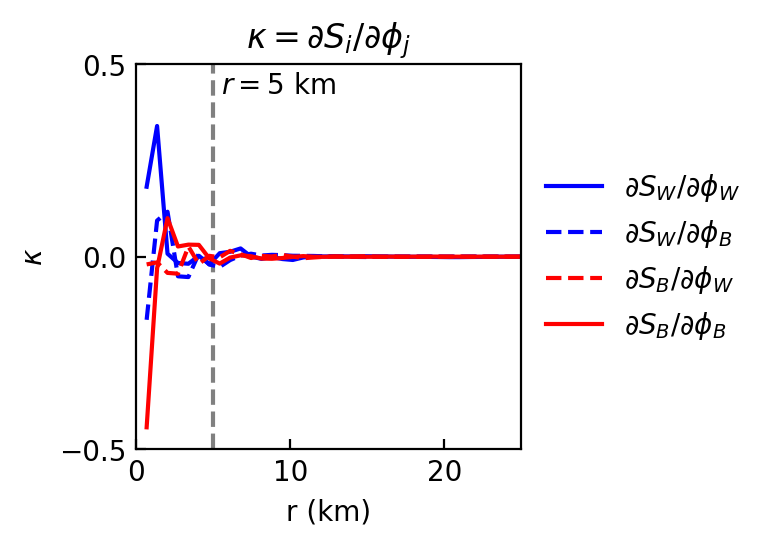

In [57]:
from scipy.interpolate import RectBivariateSpline

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.linspace(0, np.max(rgrid) / np.sqrt(2), 100)
    
    #Compute radial average
    gr = np.zeros(len(r)-1)
    for j in range(len(r)-1):
        gr[j] = np.mean(Gr[(rgrid>=r[j])*(rgrid<r[j+1])])
        
    return r[1:], gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

x = np.linspace(-xmax, xmax, 200)
y = np.linspace(-ymax, ymax, 200)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    '$\\partial S_W / \\partial \\phi_W$',
    '$\\partial S_W / \\partial \\phi_B$',
    '$\\partial S_B / \\partial \\phi_W$',
    '$\\partial S_B / \\partial \\phi_B$',
]

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax.plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i])

ax.set(xlabel='r (km)', ylabel='$\\kappa$')
ax.set(
    xlim=[0, 25],
    ylim=[-0.5, 0.5],
    xticks=[0, 10, 20],
    yticks=[-0.5, 0, 0.5])
ax.set_aspect(np.ptp(ax.get_xlim()) / np.ptp(ax.get_ylim()))
    
r0 = 5
ax.axvline(r0, linestyle='--', zorder=-1, color='grey')
ax.text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
             transform=ax.transData)
ax.tick_params(which='both', direction='in')

ax.set_title('$\\kappa = \\partial S_i / \\partial \\phi_j$')
ax.legend(framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5])

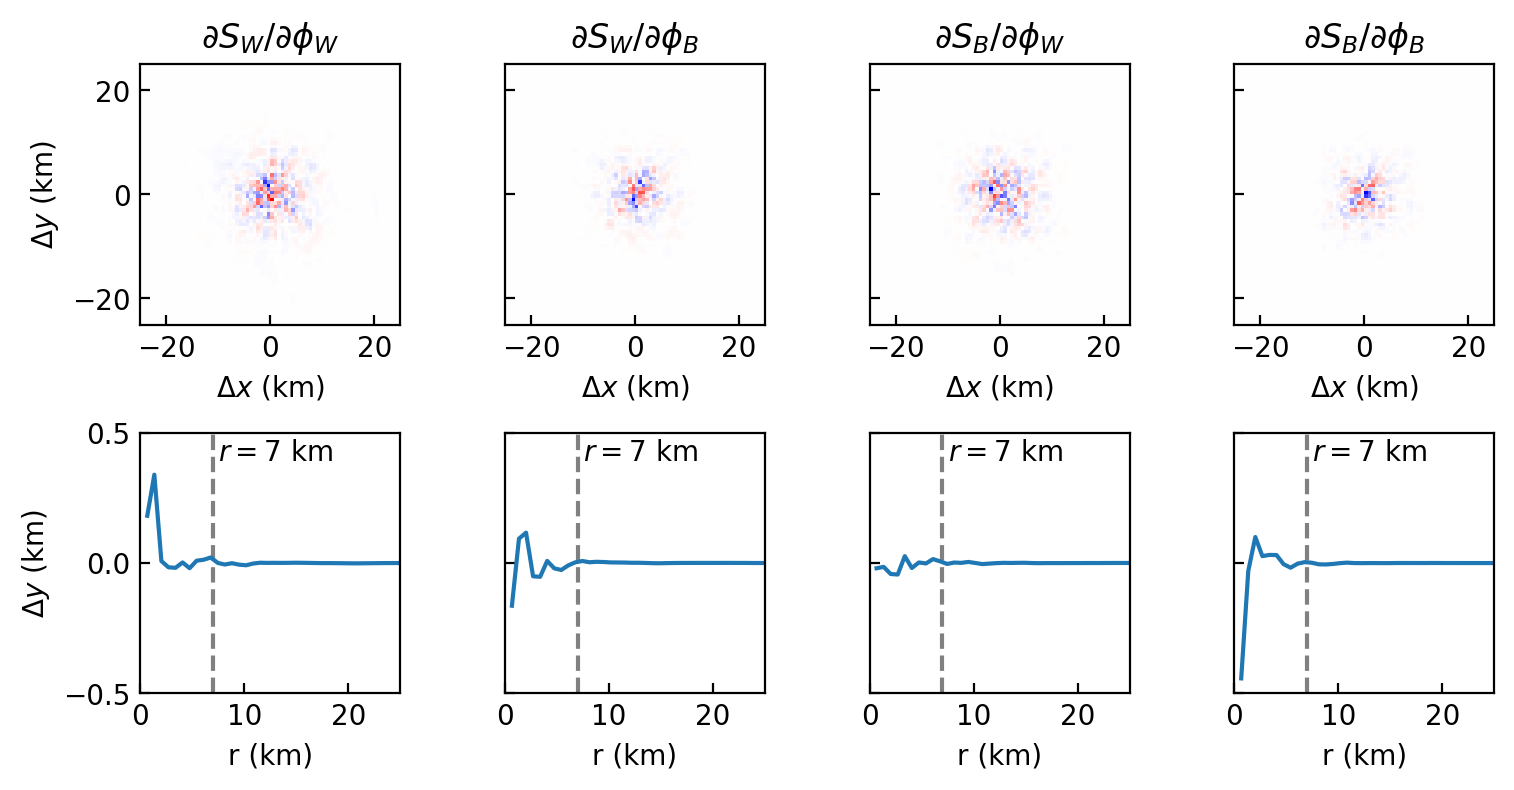

In [58]:
from scipy.interpolate import RectBivariateSpline

xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

x = np.linspace(-xmax, xmax, 200)
y = np.linspace(-ymax, ymax, 200)
x, y = np.meshgrid(x, y, indexing='xy')

rgrid = np.linalg.norm(np.stack([x, y]), axis=0)
r = np.linspace(0, np.max(rgrid) / np.sqrt(2), 100)

fig, ax = plt.subplots(2, 4, figsize=(8, 4), dpi=200, 
                       sharey='row', sharex='row')

for i in range(4):
    Gr = np.zeros(rgrid.shape)
    for j in range(4):
        Gsj = G_s[j][i//2, i%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x[0, :], y[:, 0])
        
    Gr = Gr / (4*40)
    Gr = Gr / np.abs(Gr).max()
    ax[0, i].pcolormesh(x, y, Gr,
                        vmin=-1, vmax=1, cmap='bwr')
    
    ax[0, i].set(
        xlabel=r'$\Delta x$ (km)',
        aspect='equal',
    )
    
    gr = np.zeros(len(r)-1)
    for j in range(len(r)-1):
        gr[j] = np.mean(Gr[(rgrid>=r[j])*(rgrid<r[j+1])])
    ax[1, i].plot(r[1:], gr)
    ax[1, i].set(xlabel='r (km)')
        
for i in range(4):
    ax[0,i].set(
        xlim=[-25, 25],
        ylim=[-25, 25])
    ax[1,i].set(
        xlim=[0, 25],
        ylim=[-0.5, 0.5],
        xticks=[0, 10, 20],
        yticks=[-0.5, 0, 0.5])
    ax[1,i].set_aspect(np.ptp(ax[1,i].get_xlim()) / np.ptp(ax[1,i].get_ylim()))
    
    r0 = 7
    ax[1,i].axvline(r0, linestyle='--', zorder=-1, color='grey')
    ax[1,i].text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
                 transform=ax[1,i].transData)

    ax[0,i].tick_params(which='both', direction='in')
    ax[1,i].tick_params(which='both', direction='in')
    
ax[0,0].set_ylabel(r'$\Delta y$ (km)')
ax[1,0].set_ylabel(r'$\Delta y$ (km)')

ax[0,0].set_title('$\\partial S_W / \\partial \\phi_W$')
ax[0,1].set_title('$\\partial S_W / \\partial \\phi_B$')
ax[0,2].set_title('$\\partial S_B / \\partial \\phi_W$')
ax[0,3].set_title('$\\partial S_B / \\partial \\phi_B$')

plt.tight_layout()